# Mini-Project 2: Source extraction

**Context**

This notebook illustrates the basics of distributing image data, and process them separately. In this notebook, we will load MegaCam data, and extract source positions in the CCDs. For more about Apache Spark in the context of astronomy, connect to [AstroLab Software](https://astrolabsoftware.github.io/)!

**Learning objectives**

After going through this notebook, you should be able to:

- Load and efficiently access astronomical images with Apache Spark
- Interface and use your favourite image processing package.

For this project, you will use the data at `data/images`:

In [1]:
df = spark.read.format("fits").option("hdu", 1).load("../../data/images")

In [2]:
df.show(3)

+--------------------+
|               Image|
+--------------------+
|[0.0, 0.0, 0.0, 0...|
|[0.0, 0.0, 0.0, 0...|
|[0.0, 0.0, 0.0, 0...|
+--------------------+
only showing top 3 rows



Spark SQL does not have the sense of what an image is, he knows only about rows.

**Exercise (£):** Find a way to isolate each image into one partition. Hint: each image comes from its own file.

In [3]:
from pyspark.sql.functions import input_file_name

df_images = df.withColumn("filename",input_file_name()).orderBy("filename")

In [4]:
df_images.show(1)

+--------------------+--------------------+
|               Image|            filename|
+--------------------+--------------------+
|[0.0, 0.0, 0.0, 0...|file:/home/jovyan...|
+--------------------+--------------------+
only showing top 1 row



**Exercise (££ to ££££):** Using photutils or whatever you prefer, extract position of sources in images whose peak value is 50-sigma above the background.

In [5]:
from astropy.stats import sigma_clipped_stats
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize

import numpy as np
import pandas as pd

from photutils import DAOStarFinder
from photutils import CircularAperture

from pyspark.sql.types import FloatType, ArrayType
from pyspark.sql.functions import pandas_udf, PandasUDFType


def get_stat(data, sigma=3.0, iters=3):
    """ Estimate the background and background noise using
    sigma-clipped statistics.
    
    Parameters
    ----------
    data : 2D array
        2d array containing the data.
    sigma : float
        sigma.
    iters : int
        Number of iteration to perform to get accurate estimate.
        The higher the better, but it will be longer.
    """
    mean, median, std = sigma_clipped_stats(data, sigma=sigma, iters=iters)
    return mean, median, std

def process_me_map(part):
    """ Use photutils to extract source information 
    from image (one image per partition).
    """
    data = [*part]
    
    # Reshape images for photutils
    image = np.reshape(data, (4644, 2112))
    
    # Get background statistics
    mean, median, std = get_stat(image)
    
    # Use star finder
    sf = DAOStarFinder(fwhm=10.0, threshold=50.*std)
    cat = sf(image - median)

    yield cat

In [6]:
# Use mapPartitions (NB: we could have used pandas_udf)
rdd_catalogs = df_images.select("Image").rdd.glom().mapPartitions(process_me_map)

In [7]:
# get first image and its associated catalog
first_image = df_images.select('Image').rdd.glom().take(1)
first_image = np.reshape(first_image, (4644, 2112))

first_catal = rdd_catalogs.take(1)[0]

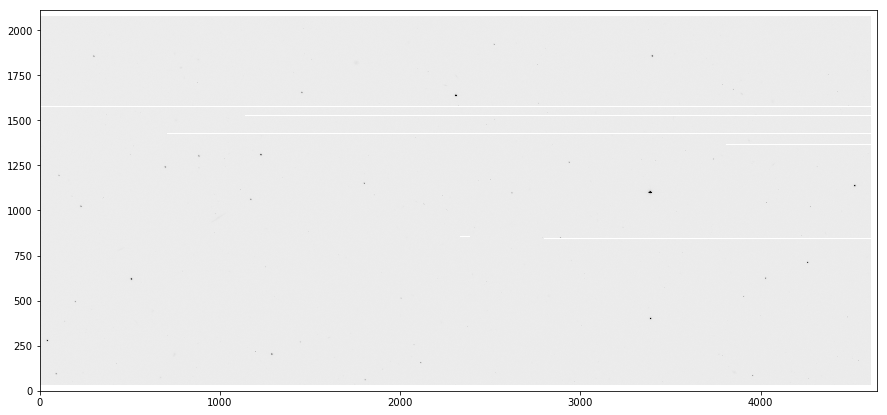

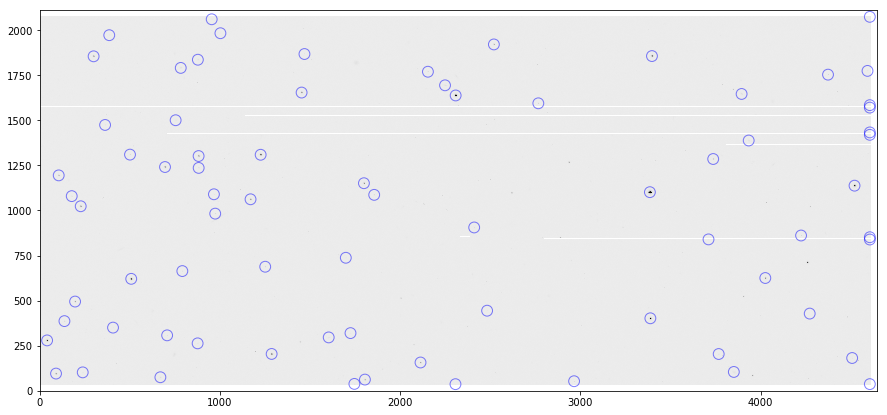

In [8]:
# Overplot detections on the CCD
import matplotlib.pyplot as plt

fig = plt.figure(0, (15, 15))
positions = (first_catal['ycentroid'], first_catal['xcentroid'])
apertures = CircularAperture(positions, r=30.)
norm = ImageNormalize(stretch=SqrtStretch())
plt.imshow(np.transpose(first_image), cmap='binary', origin="lower", norm=norm)
plt.show()

fig = plt.figure(0, (15, 15))
plt.imshow(np.transpose(first_image), cmap='binary', origin="lower", norm=norm)
apertures.plot(color='blue', lw=1.0, alpha=0.5)